In [143]:
import pandas as pd
from google.colab import drive
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Normalization, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from sklearn import model_selection
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, precision_score, recall_score, precision_recall_curve, roc_curve, auc, make_scorer
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score
import pprint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.random import set_seed
import xgboost as xgb


In [2]:
def load_data(filename, drive_path="/content/drive/", file_path="/content/drive/MyDrive/CapstoneProjectMcGill/Models/data/"):
  drive.mount(drive_path)
  df = pd.read_csv(f"{file_path}/{filename}")
  return df

In [3]:
def create_dataset(df):
  df = pd.get_dummies(df, columns=['day_of_week', "month", "grid_name", "hour_of_day"])
  Y = pd.get_dummies(df['has_accident']).values
  X = df.drop(labels=['date_of_incident', 'grid_area', 'grid_long', 'grid_lat','rues_accdn', "number_of_accident_hour", "number_of_accident_day", "has_accident"], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
  #return X_train, X_test, y_train, y_test
  scaler = MinMaxScaler()
  X_train_normalized = scaler.fit_transform(X_train)
  X_test_normalized = scaler.transform(X_test)
  return X_train_normalized, X_test_normalized, y_train, y_test

In [4]:
df = load_data("wrangled_data_balanced_july4th.csv")

Mounted at /content/drive/


In [133]:
X_train, X_test, y_train_mlp, y_test_mlp = create_dataset(df)

In [6]:
X_train.shape

(149465, 592)

In [144]:
def create_model_sequential(optimizer='adam', dropout_rate=0.2):

  set_seed(7)

  model = Sequential(
            [
                Dense(64, input_shape=(592,), activation="relu"),
                Dropout(dropout_rate),
                Dense(64, activation="relu"),
                Dropout(dropout_rate),
                Dense(128, activation="relu"),
                Dropout(dropout_rate),
                Dense(64, activation="relu"),
                Dropout(dropout_rate),
                Dense(2, activation="sigmoid"),
            ]
        )

  model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(0.001), metrics=[Precision()])

  model.summary()
  return model

def create_model(optimizer='adam', dropout_rate=0.2, hidden_layers=1, units=64, learning_rate=0.001, initializer='glorot_uniform'):
    model = Sequential()

    # Add the input layer
    model.add(Dense(units, input_shape=(592,), activation='relu', kernel_initializer=initializer))
    model.add(Dropout(dropout_rate))

    # Add the hidden layers
    for _ in range(hidden_layers):
        model.add(Dense(units, activation='relu', kernel_initializer=initializer))
        model.add(Dropout(dropout_rate))

    # Add the output layer
    model.add(Dense(2, activation='sigmoid', kernel_initializer=initializer))

    # Set the learning rate of the optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[Precision(), Recall()])
    model.summary()
    return model


def save_model(model, save_path):
  model.save(save_path)

def load_model(model, load_path):
  return load_model(load_path)

def grid_search(X_train, y_train):
  param_grid = {
      'optimizer': ['adam', 'rmsprop', 'sgd'],
      'dropout_rate': [0.2, 0.4, 0.6],
      'hidden_layers': [1, 2, 3],
      'units': [32, 64, 128],
      'learning_rate': [0.001, 0.01, 0.1],
      'initializer': ['glorot_uniform', 'he_uniform'],
      'batch_size': [16, 32, 128],
      'epochs': [10]
  }
  scoring = {
      #'precision': make_scorer(precision_score),
      'recall': make_scorer(recall_score)
  }

  model = KerasClassifier(build_fn=create_model)
  grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=3, verbose=10)
  grid_result = grid.fit(X_train, y_train)

  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  return grid_result

def train_model(model, X_train, y_train, load=True, save=True, model_path="/content/drive/MyDrive/CapstoneProjectMcGill/Models/checkpoints/", epochs=20):
  if load:
    load_model(model, model_path)
  history = model.fit(
      X_train,
      y_train,
      batch_size=32,
      epochs=epochs,
      validation_split=0.2
      #callbacks=[EarlyStopping(monitor='loss', patience=2)]
  )
  if save:
    save_model(model, model_path)
  return history


def plot_metrics(history, metric="loss"):
  plt.plot(history.history[metric], label=metric)
  plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
  plt.xlabel(metric)
  plt.ylabel(f'Error [{metric}]')
  plt.legend()
  plt.grid(True)

def evaluate_model(model, X_test, y_test):
        y_test = y_test
        y_pred = model.predict(X_test)

        if len(y_test.shape) > 1 and y_test.shape[1] > 1:
            y_pred = y_pred.argmax(axis=1)
            y_test = y_test.argmax(axis=1)
        cr = classification_report(y_test, y_pred)
        metrics = {
            #"Confusion matrix": cr,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Recall": precision_score(y_test, y_pred),
            "Precision": recall_score(y_test, y_pred),
        }
        pp = pprint.PrettyPrinter(depth=4)
        pp.pprint(metrics)
        return metrics


def evaluate_model_precison_recall(model, X_test, y_test):
        y_test = y_test
        y_pred = model.predict(X_test)

        if len(y_test.shape) > 1 and y_test.shape[1] > 1:
            y_pred = y_pred.argmax(axis=1)
            y_test = y_test.argmax(axis=1)
        cr = precision_recall_curve(y_test, y_pred)
        return cr

def evaluate_model_roc_auc(model, X_test, y_test):
    y_test = y_test
    y_pred = model.predict(X_test)

    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)
        y_test = y_test.argmax(axis=1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc, thresholds

def evaluate_model_f1_score(model, X_test, y_test):
    y_test = y_test
    y_pred = model.predict(X_test)

    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)
        y_test = y_test.argmax(axis=1)
    scoref1 = f1_score(y_test, y_pred)

    return scoref1


In [34]:
#grid_result = grid_search(X_train, y_train)

<ipython-input-33-f77e0c19dd21>:86: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START batch_size=16, dropout_rate=0.6, epochs=10, hidden_layers=2, initializer=glorot_uniform, learning_rate=0.01, optimizer=rmsprop, units=32
Epoch 1/10
6228/6228 [==============================] - 13s 2ms/step - loss: 0.5097 - accuracy: 0.7435
Epoch 2/10
6228/6228 [==============================] - 12s 2ms/step - loss: 0.4526 - accuracy: 0.7900
Epoch 3/10
6228/6228 [==============================] - 12s 2ms/step - loss: 0.4412 - accuracy: 0.7948
Epoch 4/10
6228/6228 [==============================] - 11s 2ms/step - loss: 0.4388 - accuracy: 0.7948
Epoch 5/10
6228/6228 [==============================] - 11s 2ms/step - loss: 0.4349 - accuracy: 0.7967
Epoch 6/10
6228/6228 [==============================] - 11s 2ms/step - loss: 0.4345 - accuracy: 0.7964
Epoch 7/10
6228/6228 [==============================] - 11s 2ms/step - loss: 0.4316 - accuracy: 0.7968
Epoch 8/10
6228/6228 [==============================] - 11s 

In [70]:
#model = create_model_sequential(num_classes=2, input_dim=X_train.shape[1])
model = create_model(optimizer='rmsprop', dropout_rate=0.2, hidden_layers=1, units=64, learning_rate=0.01, initializer='he_uniform')
history = train_model(model, X_train, y_train, load=False, save=True, epochs=20)

Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_311 (Dense)           (None, 64)                37952     
                                                                 
 dropout_228 (Dropout)       (None, 64)                0         
                                                                 
 dense_312 (Dense)           (None, 64)                4160      
                                                                 
 dropout_229 (Dropout)       (None, 64)                0         
                                                                 
 dense_313 (Dense)           (None, 2)                 130       
                                                                 
Total params: 42,242
Trainable params: 42,242
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
3737/3737 [==========================

In [77]:
evaluate_model(model, X_test, y_test)

2002/2002 [==============================] - 3s 1ms/step
{'Accuracy': 0.8434987589178388,
 'Precision': 0.7147720174890694,
 'Recall': 0.962487909499979}


{'Accuracy': 0.8434987589178388,
 'Recall': 0.962487909499979,
 'Precision': 0.7147720174890694}

['loss', 'precision_9', 'recall_21', 'val_loss', 'val_precision_9', 'val_recall_21']


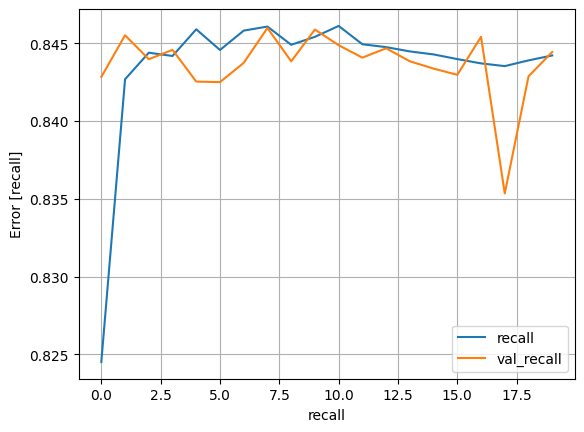

In [72]:
print([key for key in history.history])
history.history["recall"] = history.history["recall_21"]
history.history["val_recall"] = history.history["val_recall_21"]
history.history["precision"] = history.history["precision_9"]
history.history["val_precision"] = history.history["val_precision_9"]
plot_metrics(history, "recall")

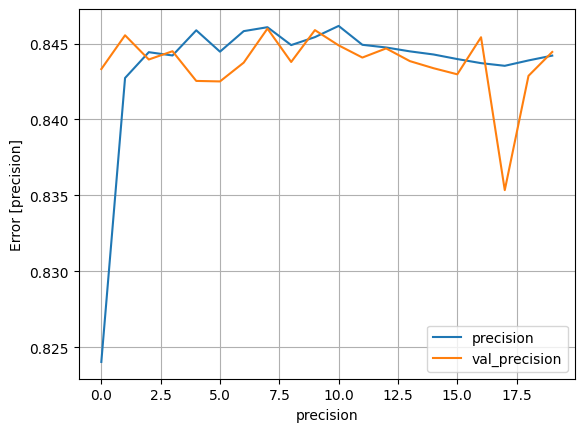

In [73]:
plot_metrics(history, "precision")

2002/2002 [==============================] - 3s 1ms/step


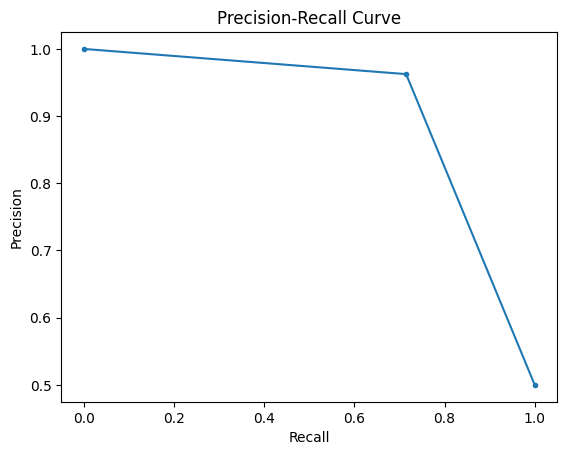

In [74]:
precision, recall, _ = evaluate_model_precison_recall(model, X_test, y_test)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(False)
plt.show()

In [132]:
fpr, tpr, roc_auc, thresholds = evaluate_model_roc_auc(model, X_test, y_test)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


2002/2002 [==============================] - 4s 2ms/step


ValueError: ignored

In [79]:
fpr

array([0.        , 0.02784281, 1.        ])

In [80]:
tpr

array([0.        , 0.71477202, 1.        ])

In [81]:
roc_auc

0.8434646053671897

LOGISTIC REGRESSION


In [100]:
def logistic_model(penalty="l1", solver="liblinear"):
  logistic = LogisticRegression(penalty=penalty, solver=solver, verbose=1)
  return logistic


In [101]:
def train_logistic(logistic, X, y):
  logistic.fit(X, y)

In [102]:
def create_dataset_linear(df):
  df = pd.get_dummies(df, columns=['day_of_week', "month", "grid_name", "hour_of_day"])
  Y = df['has_accident']
  X = df.drop(labels=['date_of_incident', 'grid_area', 'grid_long', 'grid_lat','rues_accdn', "number_of_accident_hour", "number_of_accident_day", "has_accident"], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
  #return X_train, X_test, y_train, y_test
  scaler = MinMaxScaler()
  X_train_normalized = scaler.fit_transform(X_train)
  X_test_normalized = scaler.transform(X_test)
  return X_train_normalized, X_test_normalized, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = create_dataset_linear(df)

In [104]:
base_model = logistic_model()
train_logistic(base_model, X_train, y_train)

[LibLinear]

In [105]:
evaluate_model(base_model, X_test, y_test)

{'Accuracy': 0.8452472017109761,
 'Precision': 0.7379450343535291,
 'Recall': 0.9394855075344917}


{'Accuracy': 0.8452472017109761,
 'Recall': 0.9394855075344917,
 'Precision': 0.7379450343535291}

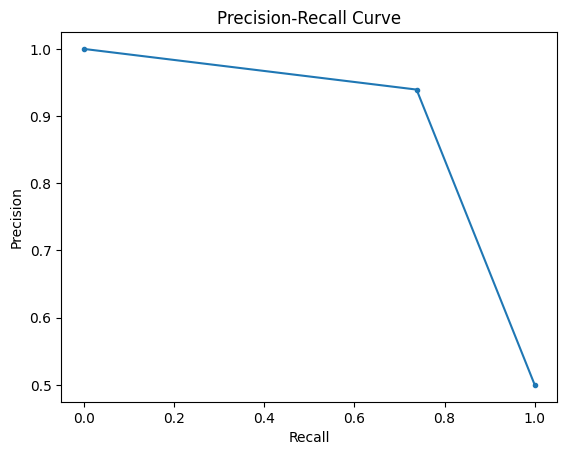

In [106]:
precision, recall, _ = evaluate_model_precison_recall(base_model, X_test, y_test)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(False)
plt.show()

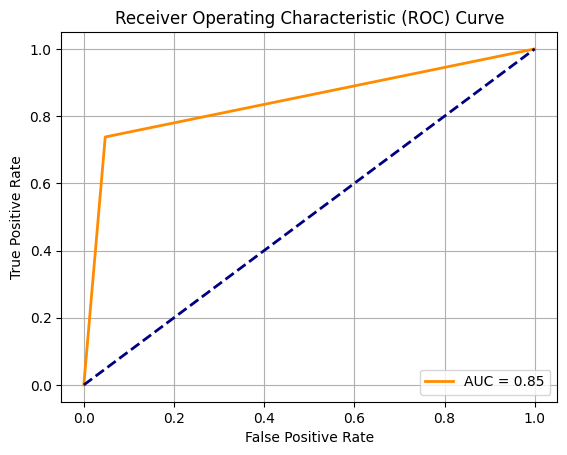

In [107]:
fpr, tpr, roc_auc, thresholds = evaluate_model_roc_auc(base_model, X_test, y_test)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [108]:
fpr, tpr, roc_auc, thresholds

(array([0.        , 0.04750757, 1.        ]),
 array([0.        , 0.73794503, 1.        ]),
 0.8452187324903083,
 array([2, 1, 0]))

XGBOOST

In [119]:
def create_model_xgb(
        n_estimators: int = 100,
        max_depth: int = 3,
        learning_rate: float = 0.01):
  classifier = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            objective="binary:logistic",
            random_state= 7,
        )
  return classifier



In [120]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = create_model_xgb()

scoring = make_scorer(recall_score)

random_search = RandomizedSearchCV(estimator=xgb_model, scoring=scoring, param_distributions=param_grid, n_iter=10, cv=3, verbose=10)
random_search.fit(X_train, y_train)

# Retrieve the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START learning_rate=0.2, max_depth=3, n_estimators=300...........
[CV 1/3; 1/10] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.967 total time=  27.4s
[CV 2/3; 1/10] START learning_rate=0.2, max_depth=3, n_estimators=300...........
[CV 2/3; 1/10] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.967 total time=  32.7s
[CV 3/3; 1/10] START learning_rate=0.2, max_depth=3, n_estimators=300...........
[CV 3/3; 1/10] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.965 total time=  33.9s
[CV 1/3; 2/10] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/3; 2/10] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=1.000 total time=  11.5s
[CV 2/3; 2/10] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/3; 2/10] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=1.000 total time=   9.7s
[CV 3/3; 2/10] START learni

In [121]:
print("Best: %f using %s" % (best_score, best_params))

Best: 1.000000 using {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}


In [122]:
xgb_model = create_model_xgb(n_estimators=100, max_depth=3, learning_rate=0.01)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=7, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

In [124]:
evaluate_model(xgb_model, X_test, y_test)

{'Accuracy': 0.8397520957896873, 'Precision': 0.679419113054341, 'Recall': 1.0}


{'Accuracy': 0.8397520957896873, 'Recall': 1.0, 'Precision': 0.679419113054341}

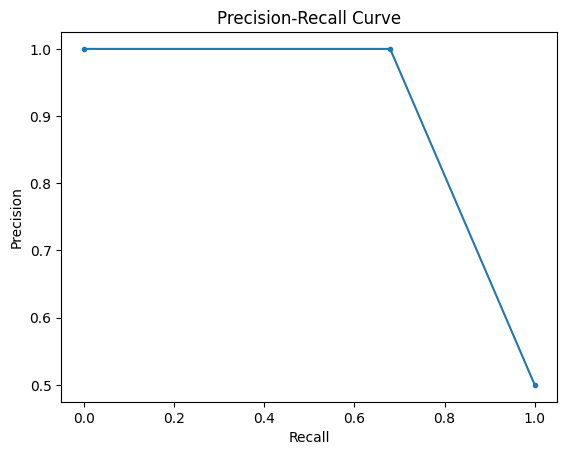

In [127]:
precision, recall, _ = evaluate_model_precison_recall(xgb_model, X_test, y_test)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(False)
plt.show()

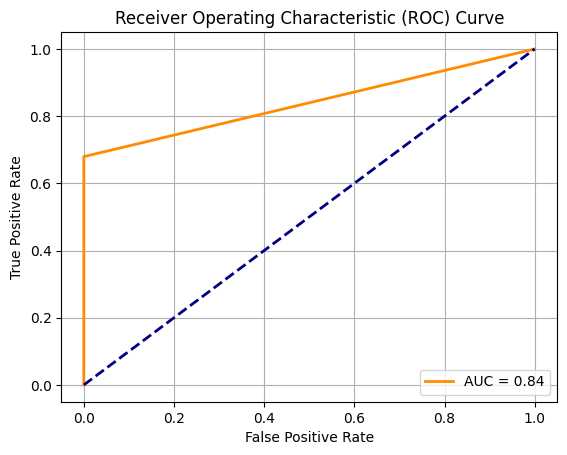

In [128]:
fpr, tpr, roc_auc, thresholds = evaluate_model_roc_auc(xgb_model, X_test, y_test)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [129]:
fpr, tpr, roc_auc, thresholds

(array([0., 0., 1.]),
 array([0.        , 0.67941911, 1.        ]),
 0.8397095565271705,
 array([2, 1, 0]))

2002/2002 [==============================] - 3s 1ms/step


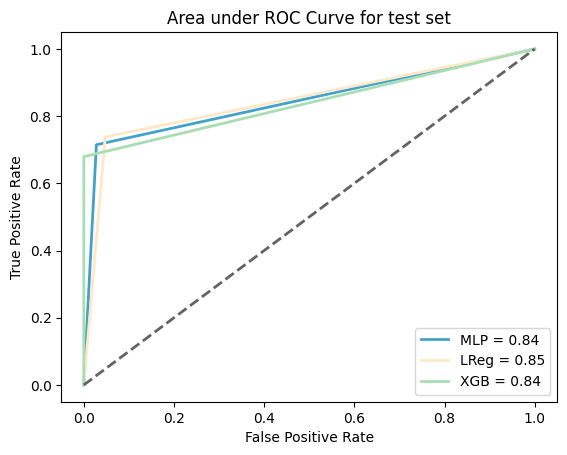

In [151]:
fpr_1, tpr_1, roc_auc_1, thresholds_1 = evaluate_model_roc_auc(model, X_test, y_test_mlp)
fpr_2, tpr_2, roc_auc_2, thresholds_2 = evaluate_model_roc_auc(base_model, X_test, y_test)
fpr_3, tpr_3, roc_auc_3, thresholds_3 = evaluate_model_roc_auc(xgb_model, X_test, y_test)

plt.plot(fpr_1, tpr_1, color='#43a2ca', lw=2, label=f'MLP = {roc_auc_1:.2f}')
plt.plot(fpr_2, tpr_2, color='#fee8c8', lw=2, label=f'LReg = {roc_auc_2:.2f}')
plt.plot(fpr_3, tpr_3, color='#a8ddb5', lw=2, label=f'XGB = {roc_auc_3:.2f}')
plt.plot([0, 1], [0, 1], color='#636363', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under ROC Curve for test set')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()


2002/2002 [==============================] - 3s 1ms/step


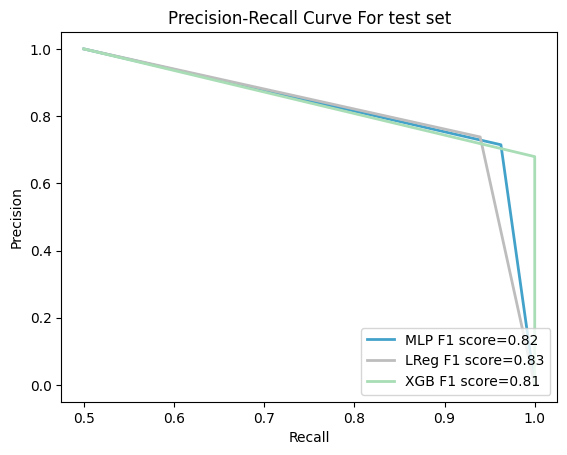

In [150]:
precision_1, recall_1, _ = evaluate_model_precison_recall(model, X_test, y_test_mlp)
f1_score_1 = evaluate_model_f1_score(model, X_test, y_test_mlp)
precision_2, recall_2, _ = evaluate_model_precison_recall(base_model, X_test, y_test)
f1_score_2 = evaluate_model_f1_score(base_model, X_test, y_test)
precision_3, recall_3, _ = evaluate_model_precison_recall(xgb_model, X_test, y_test)
f1_score_3 = evaluate_model_f1_score(xgb_model, X_test, y_test)

plt.plot(precision_1, recall_1, color='#43a2ca', lw=2, label=f'MLP F1 score={f1_score_1:.2f}')
plt.plot(precision_2, recall_2, color='#bdbdbd', lw=2, label=f'LReg F1 score={f1_score_2:.2f}')
plt.plot(precision_3, recall_3, color='#a8ddb5', lw=2, label=f'XGB F1 score={f1_score_3:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve For test set')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

0.8266078956114113